# TME 6 : Détection d'objets simples (I) : Détections de coins

> Consignes: le fichier TME6_Sujet.ipynb est à déposer sur le site Moodle de l'UE https://moodle-sciences.upmc.fr/moodle-2018/course/view.php?id=4650. Si vous êtes en binôme, renommez-le en TME6_nom1_nom2.ipynb.

N'oubliez pas de sauvegarder fréquemment votre notebook !! ...

Pour chaque questions, écrivez des commentaires brefs et concis lorsque demandé dans les cases **Commentaires**.

In [1]:
# Chargement des modules et des données utiles.

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.signal as sc
from pylab import *

# charger les images et les convertir en tableau de int
image_house = np.array(Image.open("images/house2.jpg"),dtype='int32') 
image_rectangle = np.array(Image.open("images/rectangle.png"),dtype='int32')
image_carrelage = np.array(Image.open("images/carrelage_wikipedia.jpg"),dtype='int32')
image_jussieu = np.array(Image.open("images/Jussieu_wikipedia.jpg"),dtype='int32')


def affichage_14(affichages,titres=None):
    # list[Array|Image]*list[str] -> NoneType
    # effectue entre 1 et 4 affichages avec leurs titres, pour des images ou courbes
    
    # paramètres :
    #  - liste des affichages (entre 1 et 4)
    #  - liste des titres (entre 1 et 4, autant que de affichages) Optionnelle
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('affichage_14 nécéssite 1 à 4 entrées en paramètre')        
        
    if nb_affichages != len(titres):
        raise ValueError('affichage_14 nécéssite autant de titres que d\'affichages')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

    
def module_affichage(module):
    # permet de transformer un module de DFT en une version jolie à afficher
    module = np.array(module, dtype='float32')
    ind_max = np.where(module == np.max(module.flatten()))
    module[ind_max]=0.0
    module[ind_max]=np.max(module.flatten())
    module = sqrt(module)
    return sqrt(module)

## Exercice 1 — Implémentation du filtre de Harris

Cet exercice est le prolongement de l’exercice 3 du TD 6. On cherchera ici à écrire des fonctions pour la détection de coins.

### Question 1 : Calcul des dérivées

On utilisera la fonction de convolution codée au TME 4 ou bien une fonction implémentée dans les librairies scientifiques de python (```scipy``` par exemple).

1. Écrire une fonction ```gradient()``` qui calcule la dérivée en $x$ et la dérivée en $y$ de l'image à l'aide des masques de convolution de Sobel et retourne une liste de ces dérivées. 

In [9]:
#Opérateur gradient􏰀
#Sa direction (perpendiculaire au contour) est celle dans laquelle la dérivée de I est maximale
#Ce maximum est donné par son module

def gradient(image):
    """ Array -> tuple[Array*Array]"""
    #il est plus rapide de calculer le gradient au préalable.
    #on utilise le filtre verticale et horizontale de Sobel.
    #Sobel = gradient + filtre gaussien
    #Ces filtres sont dits séparables.
    #Sobel réduit moins le bruit mais pre ́serve mieux l’information de voisinage des contours
    Gx = np.array([[-1,0,1], [-2,0,2],[-1,0,1]])
    Gy = np.array([[-1,-2,-1], [0,0,0],[1,2,1]])
    #dérivé en x et y à l'aide des masques de convolution de Sobel.
    #Filtrage “passe-haut” en y : met en evidence les contours horizontaux.
    #Filtrage “passe-bas” en x : elimination des contours dans la direction verticale.
    Ix = sc.convolve2d(image, Gx, boundary='symm', mode='same')
    Iy = sc.convolve2d(image, Gy, boundary='symm', mode='same')
    #Soit une matrice A= (Ix2 IxIy 
    #                     IxIy Iy2) 
    det = (Ix * Ix * Iy * Iy) - (Ix*Iy * Ix*Iy)
    tr = Ix*Ix + Iy*Iy
    H = det - 0.05 * tr
    return H


2. Visualiser la dérivée en $x$ et la dérivée en $y$ calculées pour les images ```image_house``` et ```image_rectangle```.

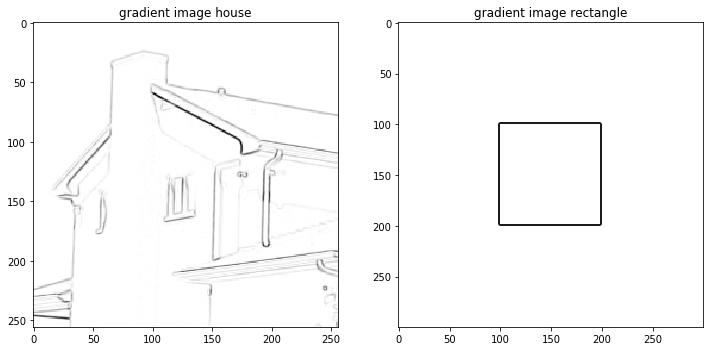

In [10]:
affichage_14([gradient(image_house), gradient(image_rectangle)],['gradient image house', 'gradient image rectangle'])


### Question 2 : Noyau gaussien

1. Écrire la fonction ```noyau_gaussien(sigma)``` qui renvoie un tableau Numpy de taille $(2N+1)\times (2N+1)$, avec $N=\lceil3\sigma\rceil$ correspondant à un noyau gaussien centré en l'origine et d'écart-type $\sigma$.

In [11]:
def noyau_gaussien(sigma):
    """ float -> Array """
    n = math.ceil(3 *sigma)
    noyau = np.zeros((2*n+1, 2*n+1))
    w, h = noyau.shape
    for x in range(w) :
        for y in range(h) :
            noyau[x,y] = (1/(2 * math.pi * sigma * sigma)) * math.exp(-((x-n)**2 + (y-n)**2)/ (2 *sigma * sigma))
            
    return noyau    

#création d'un noyau gaussien utile pour faire le produit de convolution 
#avec les dérivé de x et y trouver auparavant avec le filtre de Sobel.

2. Afficher le noyau gaussien d'écart-type 3. Quelle taille fait-il? Même question avec un écart-type de 10.

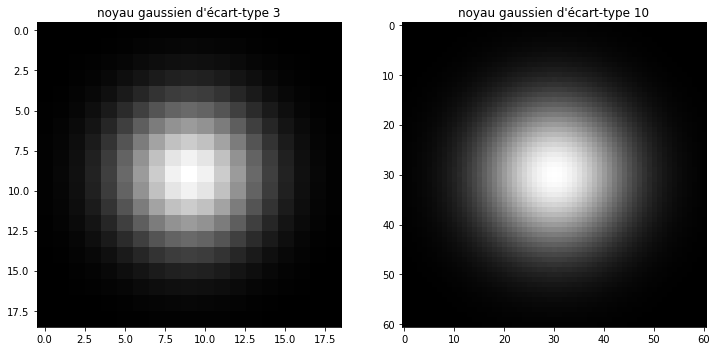

(19, 19)
(61, 61)


In [15]:
affichage_14([noyau_gaussien(3), noyau_gaussien(10)],["noyau gaussien d'écart-type 3", "noyau gaussien d'écart-type 10"])
print(noyau_gaussien(3).shape) #la taille est 19.
print(noyau_gaussien(10).shape) #la taille est 61.

### Question 3 : Calcul de l'image de Harris

1. Écrire une fonction ```harris(image, sigma, kappa)``` qui calcule l'image de Harris.

In [16]:
def harris(image, sigma, kappa):
    """ Array*float*float->Array """
    ha = np.zeros(image.shape)
    w, h = image.shape
    #question 1
    Gx = np.array([[-1,0,1], [-2,0,2],[-1,0,1]])
    Gy = np.array([[-1,-2,-1], [0,0,0],[1,2,1]])
    Ix = sc.convolve2d(image, Gx, boundary='symm', mode='same')
    Iy = sc.convolve2d(image, Gy, boundary='symm', mode='same')
    #question 2
    gauss = noyau_gaussien(sigma)
    #Il est plus simple de calculer la trace et le determinant d’une matrice 2 × 2 que ses valeurs propres
    A11 =sc.convolve2d(Ix*Ix, gauss, boundary='symm', mode='same')
    A22 =sc.convolve2d(Iy*Iy, gauss, boundary='symm', mode='same')
    A12 =sc.convolve2d(Ix*Iy, gauss, boundary='symm', mode='same')
    #on a une matrice A = (A11 A12
    #                     A12 A22)
    for x in range(w):
        for y in range(h):
            #pour chaque pixel on calcule : det(A) - k * trace(A)**2
            ha[x,y] = A11[x,y] * A22[x,y] - A12[x,y] * A12[x,y] - kappa * (A11[x,y] + A22[x,y])**2
    return ha
            
    

2. Visualisez l'image de Harris pour plusieurs images et plusieurs valeurs de paramètres.

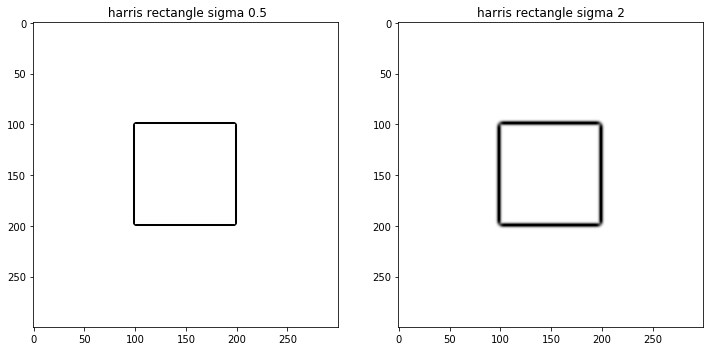

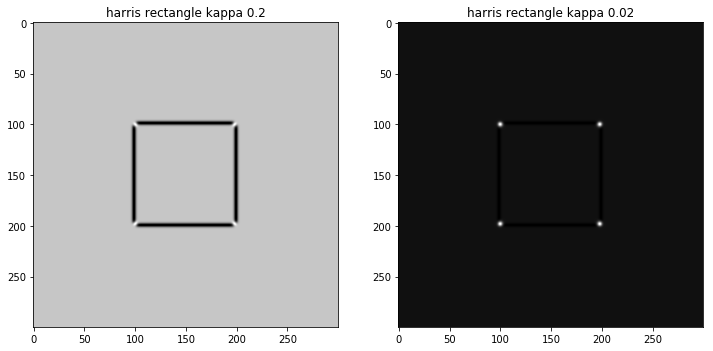

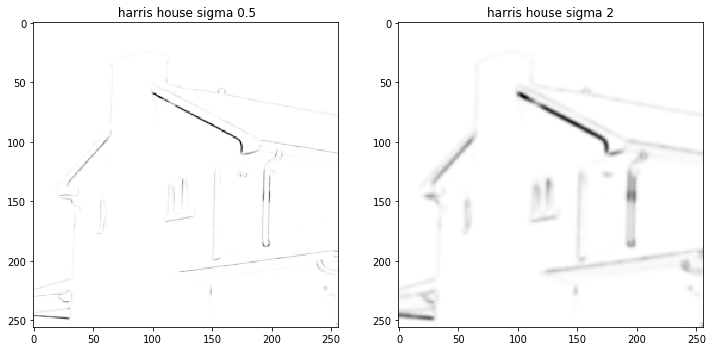

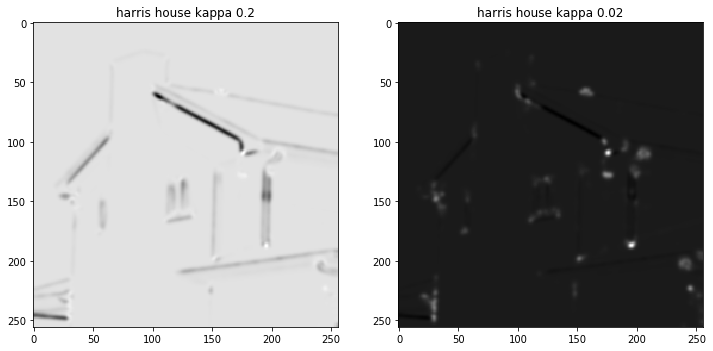

In [17]:
affichage_14([harris(image_rectangle,0.5,0.5), harris(image_rectangle, 2,0.5)],[" harris rectangle sigma 0.5", "harris rectangle sigma 2"])

affichage_14([harris(image_rectangle,2,0.2), harris(image_rectangle, 2,0.02)],["harris rectangle kappa 0.2", "harris rectangle kappa 0.02"])

affichage_14([harris(image_house,0.5,0.5), harris(image_house, 2,0.5)],[" harris house sigma 0.5", "harris house sigma 2"])

affichage_14([harris(image_house,2,0.2), harris(image_house, 2,0.02)],["harris house kappa 0.2", "harris house kappa 0.02"])

In [ ]:
#Elimination des hautes frequences avec sigma croissant.

#Une valeur trop grande de kappa ne detecte rien. 
#En pratique, on fixe ce parametre a une valeur entre 0,04 et 0,15 et l’on n’y touche guere par la suite.


## Exercice 2 : Seuillage et calcul des extrema locaux

On définit un maximum local comme un pixel dont la valeur est supérieur au seuil ```seuil``` et aux valeurs des 8 plus proches voisins. Dans cet exercice, on pourra ne pas traiter les pixels au bord de l'image.

### Question 1 :

1. Écrire un programme ```maxlocal(image_harris, seuil)``` qui prend en entrée une image de Harris et un seuil et qui renvoie un tableau numpy de même taille que l'image de Harris et dont les pixels correspondant à des maximum locaux sont à 1 et les autres à 0. On écrira une version avec parcours de l'image. Puis une version, de nom ```maxlocal_fast()``` sans parcours de l'image, uniquement à l'aide d'opération numpy 



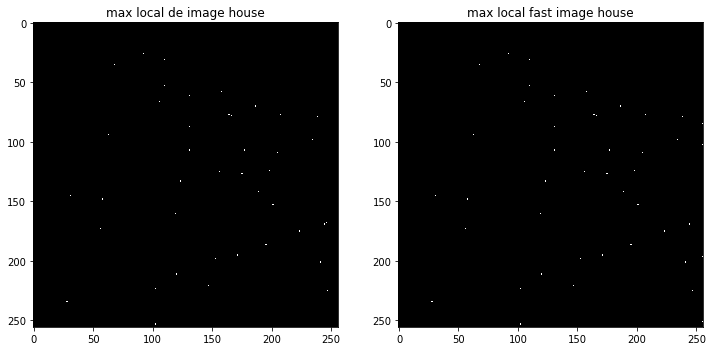

In [18]:
def maxlocal(image_harris, seuil):
    """ Array*float -> Array """
    
    tab = np.zeros(image_harris.shape)
    w, h = image_harris.shape
    for x in range(1,w-1) :
        for y in range(1,h-1) :
            if image_harris[x,y] > seuil :
                p = image_harris[x,y]
                if ((image_harris[x-1,y-1] < p)and (image_harris[x-1,y] < p) and(image_harris[x, y-1] < p) and (image_harris[x+1,y+1] < p) and (image_harris[x+1,y] < p)and (image_harris[x,y+1] < p) and (image_harris[x-1,y+1] < p) and(image_harris[x+1,y] < p)) :
                    tab[x,y] = 1
    return tab

def maxlocal_fast(image_harris,seuil):
    #on définit les 8 voisins du pixel.
    i1 = np.roll(image_harris, -1, axis = 0)
    i2 = np.roll(image_harris, -1, axis = 1)
    i3 = np.roll(image_harris, 1, axis = 1)
    i4 = np.roll(image_harris, 1, axis = 0)
    i5 = np.roll(i1, -1, axis = 1)
    i6 = np.roll(i1, 1, axis = 1)
    i7 = np.roll(i4, -1, axis = 1)
    i8 = np.roll(i4, 1, axis = 1)
    return ((image_harris>seuil) & (image_harris > i1) & (image_harris > i2) & (image_harris > i3) & (image_harris > i4) & (image_harris > i5) & (image_harris > i6) & (image_harris > i7) & (image_harris > i8))

affichage_14([maxlocal(harris(image_house, 5,0.02), 10**6),maxlocal_fast(harris(image_house, 5,0.02), 10**6)],['max local de image house', 'max local fast image house'])


2. Test la fonction ``maxlocal()`` sur l'image ``rectangle``. Afficher l'image des extrema et le nombre d'extrema détecté par la méthode d'Harris. Comparer les temps en utilisant cette fois la fonction ``maxlocal_fast()``.

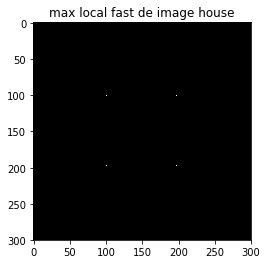

(300, 300)
0.29551000000000016


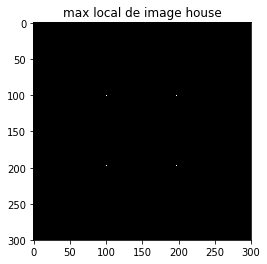

(300, 300)
0.3996959999999987


In [19]:
from time import process_time
mytime = 0
def tic():
    global mytime
    mytime = process_time()
def tac():
    global mytime
    print (process_time()-mytime)
    mytime = process_time()

image_rect_harris = harris(image_rectangle,5,0.02)   
    
tic()
m = maxlocal_fast(image_rect_harris,10**6)
affichage_14([m],['max local fast de image house'])
print(m.shape)
tac()

tic()
m = maxlocal(image_rect_harris,10**6)
affichage_14([m],['max local de image house'])
print(m.shape)
tac()


#La fonction max local fast est légèrement plus rapide que celle qui utilise le parcours de l'image.

2. Modifier le programme et écrire ``coord_maxlocal(image_extrema, seuil)`` pour qu'il renvoit une liste des coordonnées des maxima locaux trouvés dans ``image_extrema``. Une coordonnée est une liste de deux entiers. On testera cette fonction sur l'image ``image_rectangle`` en imprimant les coordonnées des maxima locaux.


In [20]:
def coord_maxlocal(image_extrema):
    """ Array -> list[list[int,int]] """
    
    w, h = image_extrema.shape
    t = []
    for x in range(w) :
        for y in range(h) :
            if(image_extrema[x,y] == 1) :
                t.append([x,y])
    return t


In [21]:
print(coord_maxlocal(m))

[[101, 101], [101, 197], [197, 101], [197, 197]]


3. Visualisation: on souhaite supperposer les coins trouvées au dessus l''image. Les coins seront affichés sous la forme d'un cercle rouge. Ceci est possible à l'aide de la fonction ``scatter(x,y,color='red')`` du module ``matplotlib.pyplot``, où ``x`` est le vecteur des abscisses des points à afficher et ``y`` le vecteur des ordonnées correspondantes. Donner le code Python correspondant 
    

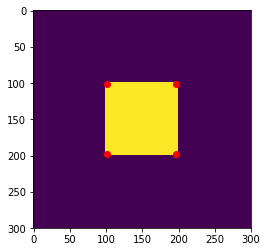

In [22]:
def visualisation(image, m):
    t = coord_maxlocal(m)
    x = []
    y = []
    #on remplie la liste x des des abscisses et la liste y des ordonnées des points à afficher.
    for i in range(len(t)):
        x.append(t[i][0])
        y.append(t[i][1])
    
    plt.imshow(image)
    plt.scatter(y, x, color='red')
    plt.show()
    
    
visualisation(image_rectangle,m)


## Exercice 3 : Expérimentations

### Question 1
Expérimentez pour plusieurs images le détecteur de points de Harris avec plusieurs valeurs des paramètres sigma, kappa et seuil et en affichant l'image et les coins détectés en rouge.

Remarque importante: si les points détectés ne semblent pas correspondre visuellement à ce que vous voyez dans l'image, lisez la documentation de ```scatter()``` et revoyez éventuellement la fonction ``coord_maxlocal()``.


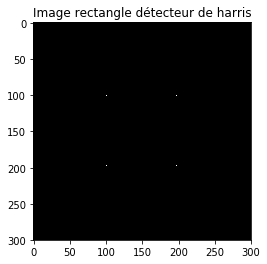

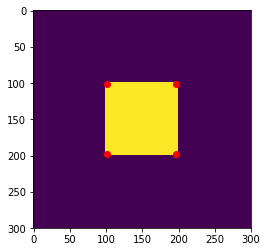

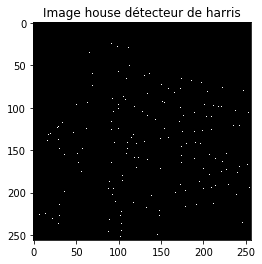

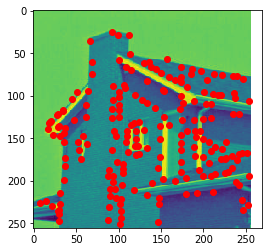

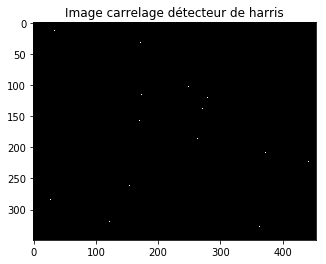

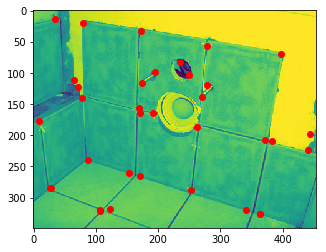

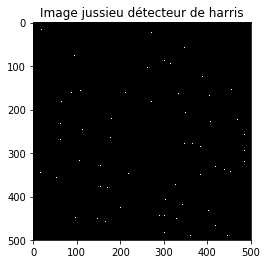

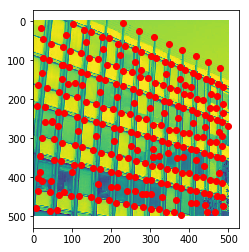

In [23]:
m_r = maxlocal(harris(image_rectangle,5,0.02),10**6)
m_h = maxlocal(harris(image_house,2,0.02),10**6)
m_c = maxlocal(harris(image_carrelage,5,0.2),10**6)
m_j = maxlocal(harris(image_jussieu,5,0.02),10**5)

affichage_14([m_r],['Image rectangle détecteur de harris'])
v_r = visualisation(image_rectangle,m_r)
affichage_14([m_h],['Image house détecteur de harris'])
v_h = visualisation(image_house,m_h)
affichage_14([m_c],['Image carrelage détecteur de harris'])
v_c = visualisation(image_carrelage,m_c)
affichage_14([m_j],['Image jussieu détecteur de harris'])
v_r = visualisation(image_jussieu,m_j)

### Question 2

Considerez le détecteur de point vu en cours, c'est-à-dire une convolution avec le noyau 
$\begin{pmatrix} -1 & -1 & -1 \\ -1 & 8 & -1 \\ -1 & -1 & -1 \end{pmatrix}$. Là encore, il faudra déterminer les maxima locaux ainsi que leur coordonnées pour les afficher.



-765 0.0 1275
-765 0.0 1275


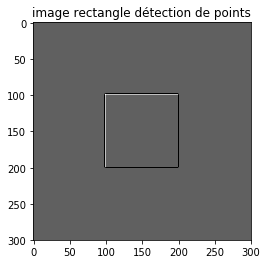

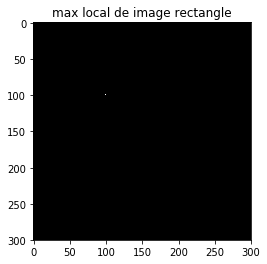

[[101, 101], [101, 197], [197, 101], [197, 197]]
[[99, 99], [99, 199], [199, 99], [199, 199]]


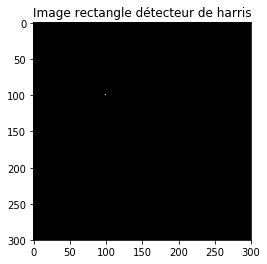

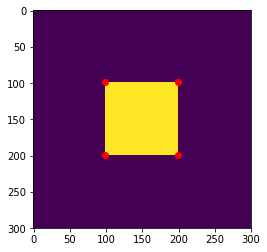

In [25]:
def point(image):
    """ Array*float*float->Array """
    #detection de points/contours isolés on utilise l'algo vu en cours.
    #ce filtre repond plus fortement sur un point de contour isole que sur un groupement de points de contour.
    lap = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    #on fait la convolution
    detr = sc.convolve2d(image,lap,'same')
    print(detr.min(),detr.mean(),detr.max())
    return detr
   
p = point(image_rectangle)  
mp = maxlocal(point(image_rectangle),1000)
affichage_14([p],["image rectangle détection de points"])
affichage_14([mp],['max local de image rectangle'])
print(coord_maxlocal(m))
print(coord_maxlocal(mp))

affichage_14([mp],['Image rectangle détecteur de harris'])
visualisation(image_rectangle,mp)

-513 7.2878265380859375 1035


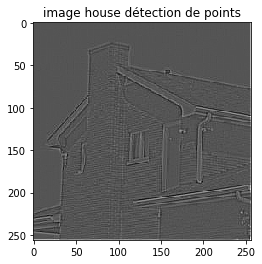

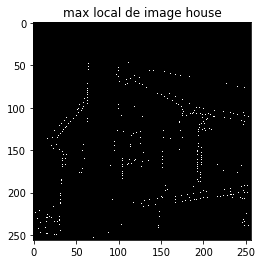

[[47, 112], [48, 65], [50, 112], [52, 65], [53, 100], [55, 65], [56, 100], [56, 136], [56, 141], [57, 65], [57, 147], [57, 161], [58, 154], [60, 104], [60, 161], [61, 98], [61, 165], [61, 167], [62, 119], [62, 173], [63, 109], [63, 122], [63, 157], [64, 100], [64, 111], [64, 183], [65, 125], [65, 191], [66, 114], [67, 109], [67, 117], [69, 101], [69, 120], [70, 109], [70, 122], [72, 64], [72, 110], [72, 125], [72, 227], [73, 108], [73, 128], [75, 131], [75, 240], [76, 133], [76, 248], [77, 135], [77, 149], [78, 64], [78, 151], [79, 138], [80, 64], [82, 64], [82, 144], [83, 104], [83, 146], [83, 160], [84, 162], [85, 64], [85, 150], [86, 165], [87, 154], [87, 167], [88, 64], [89, 60], [89, 157], [90, 159], [91, 175], [92, 64], [92, 163], [94, 59], [95, 64], [95, 168], [95, 183], [96, 54], [96, 100], [96, 170], [97, 61], [97, 173], [99, 59], [99, 119], [99, 174], [100, 50], [100, 192], [100, 195], [101, 53], [101, 58], [101, 100], [101, 200], [102, 52], [102, 175], [103, 56], [103, 189],

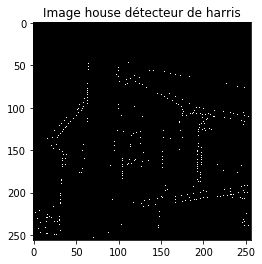

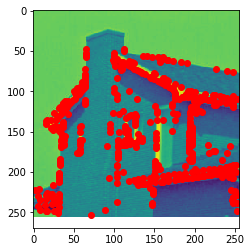

In [26]:
ph = point(image_house)  
mh = maxlocal(ph,150)
affichage_14([ph],["image house détection de points"])
affichage_14([mh],['max local de image house'])
print(coord_maxlocal(mh))

affichage_14([mh],['Image house détecteur de harris'])
visualisation(image_house,mh)